# Cours PCD – Labo 6 : Extraction d’attributs à partir de textes en vue de la classification

In [1]:
import numpy as np
import pandas as pd

from nltk.corpus import reuters
from sklearn.model_selection import GridSearchCV

## Exercice 1

Chargement des IDs nécéssaires

In [2]:
train_ids = [fid for fid in reuters.fileids() if fid.startswith("train")]
test_ids = [fid for fid in reuters.fileids() if fid.startswith("test")]

print(f"Nombre de fichiers d'entraînement: {len(train_ids)}")
print(f"Nombre de fichiers de test: {len(test_ids)}")
print(f"Nombre de fichiers total: {len(train_ids)+len(test_ids)}")

Nombre de fichiers d'entraînement: 7769
Nombre de fichiers de test: 3019
Nombre de fichiers total: 10788


## Exercice 2

Chargement des données dans des `DataFrame`:

In [3]:
def reuters_to_df(reuters, fids, category="grain"):
    return pd.DataFrame({
        "text" : map(lambda fid: " ".join(reuters.words(fid)), fids),
        "category" : map(lambda fid: 1 if category in reuters.categories(fid) else 0, fids)
    })

In [4]:
train = reuters_to_df(reuters, train_ids)
test = reuters_to_df(reuters, test_ids)
train.head()
test.head()

,text,category
0,ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPA...,0
1,CHINA DAILY SAYS VERMIN EAT 7 - 12 PCT GRAIN S...,1
2,JAPAN TO REVISE LONG - TERM ENERGY DEMAND DOWN...,0
3,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Tha...,1
4,INDONESIA SEES CPO PRICE RISING SHARPLY Indone...,0


# Exercice 3

In [5]:
from pprint import pprint
from time   import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model            import SGDClassifier
from sklearn.model_selection         import GridSearchCV
from sklearn.pipeline                import Pipeline

# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline(
    [
        ("vect",  CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf",   SGDClassifier()),   # Do not modify for this laboratory (always SGDClassifier() -> SVM)
    ]
)

# Parameters to use for grid search. Uncommenting more parameters will give
# better exploring power but will increase processing time in a combinatorial
# way
parameters = {
    "vect__max_df": (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    "clf__max_iter": (20,),
    "clf__alpha": (0.00001, 0.000001),
    "clf__penalty": ("l2", "elasticnet"),
    # 'clf__max_iter': (10, 50, 80),
}

# Find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1) # Cross validation!

def trainModelAndDisplayParametersAndScores(pipeline, parameters, train):
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(train['text'], train['category'])
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
trainModelAndDisplayParametersAndScores(pipeline, parameters, train)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (20,),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
done in 75.235s

Best score: 0.993
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 20
	clf__penalty: 'elasticnet'
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)


#### Recherche du meilleur modéle : 

D'abord on cherche les meilleurs paramètres pour la cross validation, et par la suite et en fonctions des parametres trouvés on va  changer les composantes de pipeline.


In [6]:
pipeline = Pipeline(
    [
        ("vect",  CountVectorizer(analyzer='word', stop_words='english')),
        ("tfidf", TfidfTransformer()),
        ("clf",   SGDClassifier()),
    ]
)

parameters = {
    "vect__max_df": (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    "clf__max_iter": (20,),
    "clf__alpha": (0.00001, 0.000001),
    "clf__penalty": ("l2", "elasticnet"),
    #'clf__max_iter': (10, 50, 80),
}


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

trainModelAndDisplayParametersAndScores(pipeline, parameters, train)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (20,),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
done in 66.390s

Best score: 0.994
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 20
	clf__penalty: 'elasticnet'
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)


## Exercice 4
Le score sur les données de test de la meilleure configuration que vous avez
obtenue ci-dessus :

In [7]:
y_pred = grid_search.predict(test['text'])

Matrice de confusion :


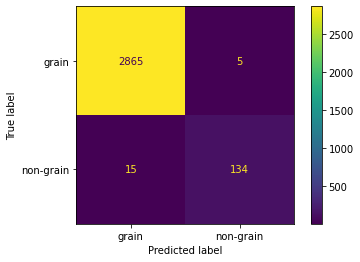



Scores :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2870
           1       0.96      0.90      0.93       149

    accuracy                           0.99      3019
   macro avg       0.98      0.95      0.96      3019
weighted avg       0.99      0.99      0.99      3019



In [8]:
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib      import pyplot as pl

print("Matrice de confusion :")
conf_mat = confusion_matrix(test['category'],y_pred)

fig = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=['grain','non-grain'])
fig.plot()
pl.show()

print('\n')

print("Scores :")
print(classification_report(test['category'], y_pred))

 ##### Score si on classe toutes les dépêches comme non-‘grain :

Matrice de confusion :


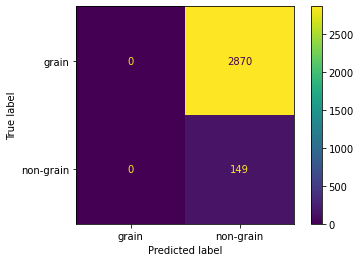



Scores :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2870
           1       0.05      1.00      0.09       149

    accuracy                           0.05      3019
   macro avg       0.02      0.50      0.05      3019
weighted avg       0.00      0.05      0.00      3019



In [9]:
import numpy as np


y_all_non_grain = np.array(len(y_pred) * [1])

print("Matrice de confusion :")
conf_mat = confusion_matrix(test['category'],y_all_non_grain)

fig = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=['grain','non-grain'])
fig.plot()
pl.show()

print('\n')

print("Scores :")
print(classification_report(test['category'], y_all_non_grain, zero_division=0))

### Conclusion :

Le modèle établi au début donne un f1-score de 1 pour la classe 'non-grain' et un f1-score de 0.93 pour la classe 'grain', qui sont de très bons scores, par contre on peut observer que tout les documents ou presque on était mal classé si si on classe toutes les dépêches comme non-‘grain, et que tous les indicateurs de scores sont extrêmement mauvais, donc on peut affirmer que c'est une mauvaise idée d'utiliser le modèle 2.
